# Machine Intelligence 9

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import math
import random

In [16]:
def generate_data_of_size(size):
  data = []
  half_size = int(size/2)
  for i in range (half_size):
    if np.random.binomial(1, 0.5) == 0:
        data.append([np.random.multivariate_normal(np.array([0,1]).T, [[0.1, 0], [0,0.1]]), -1])
    else:
        data.append([np.random.multivariate_normal(np.array([1,0]).T, [[0.1, 0], [0, 0.1]]), -1])
  for i in range (half_size):
      if np.random.binomial(1, 0.5) == 0:
          data.append([np.random.multivariate_normal(np.array([0,0]).T, [[0.1, 0],[0,0.1]]), 1])
      else:
          data.append([np.random.multivariate_normal(np.array([1,1]).T, [[0.1, 0],[0,0.1]]), 1])
  return data

def generate_data_of_size_w_chunks(size, chunks=10):
  normal_order_data_i = []
  normal_order_data_ii = []
  chucked_order_data = []
  chunk_size = int(size/chunks)
  half_chunk_size = int(chunk_size/2)
  for i in range (chunks):
    generated_chunk = generate_data_of_size(chunk_size)
    chucked_order_data += generated_chunk
    normal_order_data_i += generated_chunk[0:half_chunk_size]
    normal_order_data_ii += generated_chunk[half_chunk_size:]
  return (normal_order_data_i + normal_order_data_ii), chucked_order_data

data, chunked_data = generate_data_of_size_w_chunks(80, chunks=10)
x1 =[d[0][0] for d in data]
x2 =[d[0][1] for d in data]
y = np.array([d[1] for d in data])
X_train = np.array(list(zip(x1,x2)))

holdout = generate_data_of_size(80)
x1h =[d[0][0] for d in holdout]
x2h =[d[0][1] for d in holdout]
yh = np.array([d[1] for d in holdout])
X_holdout = np.array(list(zip(x1,x2)))

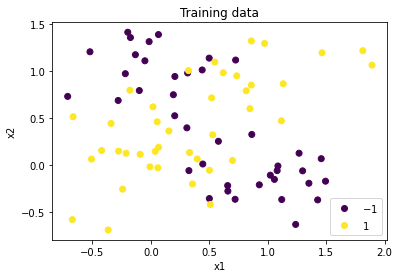

In [17]:
scatter = plt.scatter(x1, x2, c = y)
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(*scatter.legend_elements()) 
plt.title('Training data')
plt.show()

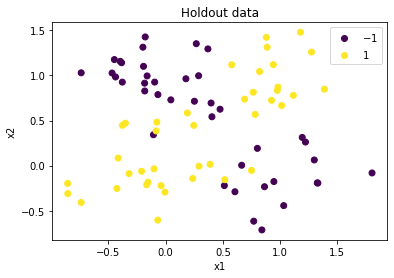

In [18]:
scatter = plt.scatter(x1h, x2h, c = yh)
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(*scatter.legend_elements()) 
plt.title('Holdout data')
plt.show()

In [19]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import svm

In [20]:
# csvm_1 = svm.SVC(kernel = 'rbf', gamma='auto')
csvm_1 = make_pipeline(StandardScaler(), SVC(gamma='auto'))
csvm_1.fit(X_train, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

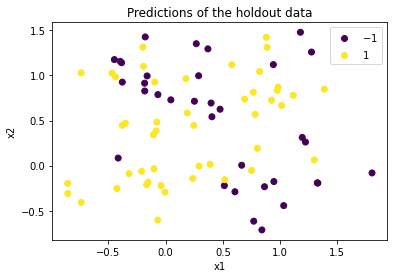


WOWW, so accurate 👍


In [21]:
predictions = csvm_1.predict(X_holdout)

scatter = plt.scatter(x1h, x2h, c = predictions)
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(*scatter.legend_elements()) 
plt.title('Predictions of the holdout data')
plt.show()
print("\nWOWW, so accurate 👍")

In [22]:
from sklearn.metrics import confusion_matrix
confusion_matrix(yh, predictions, labels=[-1,1])

array([[30, 10],
       [ 4, 36]])

In [23]:
from sklearn.metrics import accuracy_score
perc_correct = accuracy_score(yh, predictions, normalize = True)
print('The percentage of correct predictions is: ', perc_correct)
print('The percentage of wrong predictions is: ', 1 - perc_correct)

The percentage of correct predictions is:  0.825
The percentage of wrong predictions is:  0.17500000000000004


number of support vectors:  46


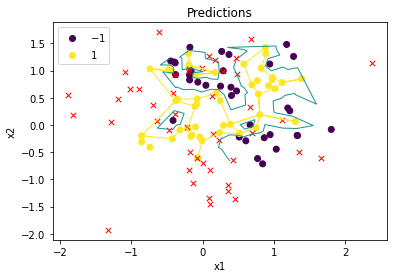

In [24]:
plt.scatter(x1h, x2h, c = predictions)
plt.tricontour(x1h, x2h, predictions, 1, linewidths=1)
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(*scatter.legend_elements()) 
plt.title('Predictions')
plt.scatter(csvm_1['svc'].support_vectors_[:, 0], csvm_1['svc'].support_vectors_[:, 1], s=30, marker = 'x', linewidth=1, facecolors='red', edgecolors='k', label = 'support vectors')
print("number of support vectors: ", len(csvm_1['svc'].support_vectors_))

## Exercise H9.3: C-SVM parameter optimization

### a) Using grid search and cross-validation (aka. brute force)

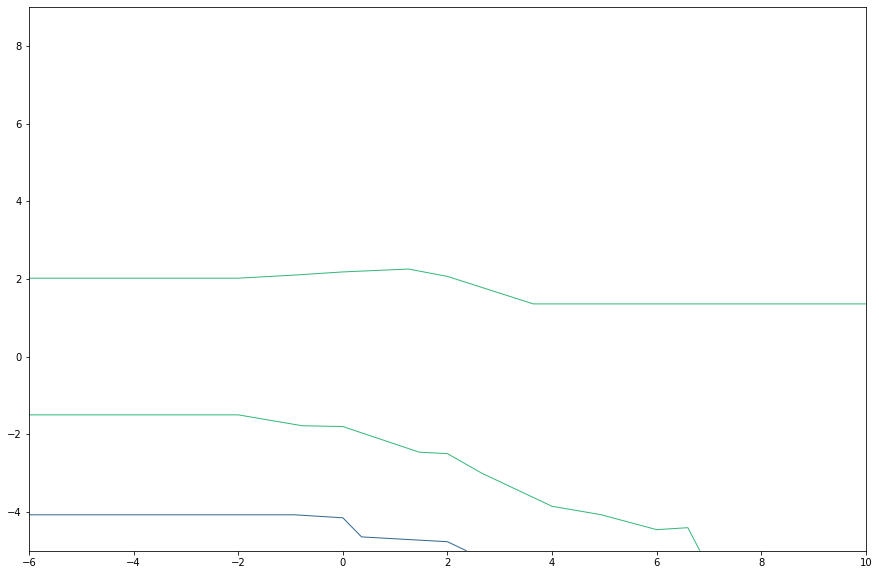

In [25]:
import itertools
from matplotlib.pyplot import figure

x1_chunked =[d[0][0] for d in chunked_data]
x2_chunked =[d[0][1] for d in chunked_data]
y_chunked = np.array([d[1] for d in chunked_data])
X_train_chunked = np.array(list(zip(x1_chunked, x2_chunked)))

C      = [2**i for i in range(-6,12,2)]
gammas = [2**i for i in range(-5,11,2)]

folds = 10
batch_len = int(len(X_train)/folds)
grid_search = []

for c, gamma in list(itertools.product(C, gammas)):
  accuracy_sum = 0
  # print("-- For C: {}, gamma: {}".format(c, gamma))
  for i in range(folds):
    indx = i*batch_len
    X_train_train = X_train_chunked[indx:indx+batch_len]
    X_train_test = np.concatenate((X_train_chunked[indx+batch_len:], X_train_chunked[:indx]), axis=0)
    y_train = y_chunked[indx:indx+batch_len]
    y_test = np.concatenate((y_chunked[indx+batch_len:], y_chunked[:indx]), axis=0)

    # csvm = svm.SVC(kernel = 'rbf', C=c, gamma=gamma)
    csvm = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=c, gamma=gamma))
    csvm.fit(X_train_train, y_train)
    predictions = csvm.predict(X_train_test)
    perc_correct = accuracy_score(y_test, predictions, normalize = True)
    # print("---- Accuracy: ", perc_correct)
    accuracy_sum += perc_correct
  total_accuracy = accuracy_sum / folds
  grid_search.append([(c, gamma), total_accuracy])
  # print("-------- Total: ", total_accuracy, "\n")

grid_cs = [math.log(g[0][0], 2) for g in grid_search]
grid_gs = [math.log(g[0][1], 2) for g in grid_search]
grid_ac = [g[1]*100 for g in grid_search]

figure(figsize=(15,10))
plt.tricontour(grid_cs, grid_gs, grid_ac, 1, linewidths=1)

**b) Finding the best C, gamma combination and use it to train the dataset**

Best combination:  [(1, 2), 0.6958333333333334]


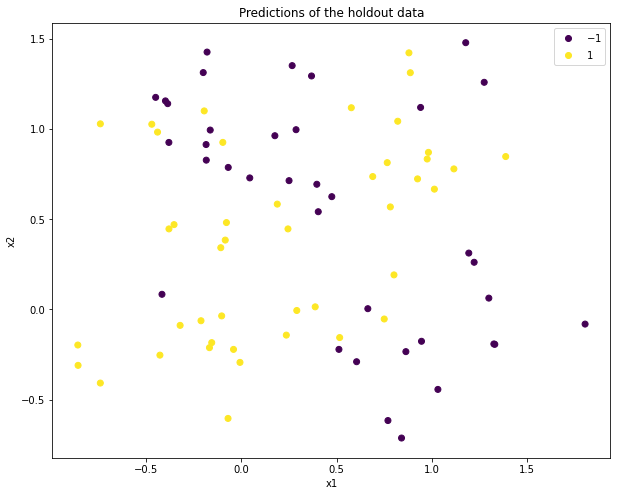

The percentage of correct predictions is:  0.8625


In [26]:
# Sorting by performance (desc)
grid_search.sort(key=lambda x: x[1], reverse=True)

# Best combination (first one)
best_combination = grid_search[0]
print("Best combination: ", best_combination)
best_c, best_gamma = best_combination[0]

# csvm_best = svm.SVC(kernel = 'rbf', C=best_c, gamma=best_gamma)
csvm_best = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=best_c, gamma=best_gamma))
csvm_best.fit(X_train, y)

best_predictions = csvm_best.predict(X_holdout)

figure(figsize=(10,8))
scatter = plt.scatter(x1h, x2h, c = best_predictions)
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(*scatter.legend_elements()) 
plt.title('Predictions of the holdout data')
plt.show()

perc_correct_best = accuracy_score(yh, best_predictions, normalize = True)
print('The percentage of correct predictions is: ', perc_correct_best)

**c) Comparison with the default values**

number of support vectors:  56


Analysis; 
 - Minor improvement in the overall performance
 - 10 more support vectors are used
 - Dividing C by 4 (as seen in next section) doesn't really improve anything



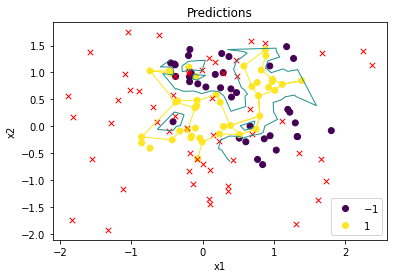

In [31]:
plt.scatter(x1h, x2h, c = best_predictions)
plt.tricontour(x1h, x2h, best_predictions, 1, linewidths=1)
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(*scatter.legend_elements()) 
plt.title('Predictions')
plt.scatter(csvm_best['svc'].support_vectors_[:, 0], csvm_best['svc'].support_vectors_[:, 1], s=30, marker = 'x', linewidth=1, facecolors='red', edgecolors='k', label = 'support vectors')
print("number of support vectors: ", len(csvm_best['svc'].support_vectors_))

print("""

Analysis; 
 - Minor improvement in the overall performance
 - 10 more support vectors are used
 - Dividing C by 4 (as seen in next section) doesn't really improve anything
""")

**c-ii) Dividing C by 4**

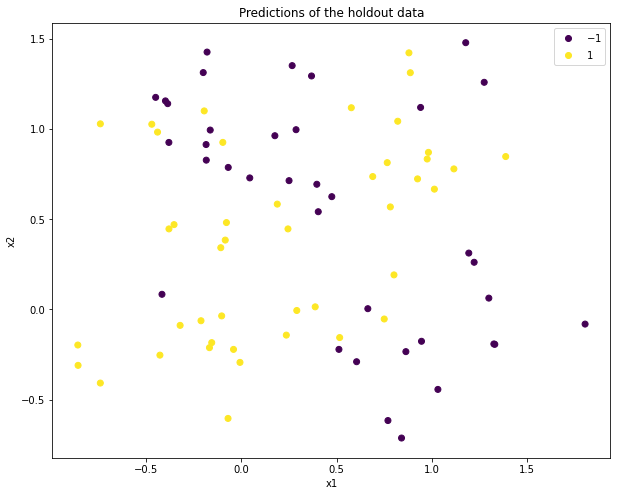

The percentage of correct predictions is:  0.8625


In [29]:
c = best_c / 4

csvm = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=c, gamma=best_gamma))
csvm.fit(X_train, y)

predictions = csvm_best.predict(X_holdout)

figure(figsize=(10,8))
scatter = plt.scatter(x1h, x2h, c = predictions)
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(*scatter.legend_elements()) 
plt.title('Predictions of the holdout data')
plt.show()

perc_correct = accuracy_score(yh, predictions, normalize = True)
print('The percentage of correct predictions is: ', perc_correct)